In [69]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, f1_score
import csv
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os

# Set seed for reproducibility
def set_seed(seed_value=42):
    np.random.seed(seed_value)

set_seed(42)

# Load dataset
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

print(df.describe())
print(df.info())


# Replace zeros with NaN where applicable
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

# Calculate the counts of each class (outcome 0 and 1)
outcome_counts = df['Outcome'].value_counts()

# Total number of samples
total_samples = len(df)

# Number of classes
num_classes = 2

# Calculate class weights using the formula: n / (k * n_j)
balanced_class_weight = {
    0: total_samples / (num_classes * outcome_counts[0]),
    1: total_samples / (num_classes * outcome_counts[1])
}

# Print outcome counts and class weights
print("Outcome Counts:", outcome_counts)
print("Class Weights:", balanced_class_weight)


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

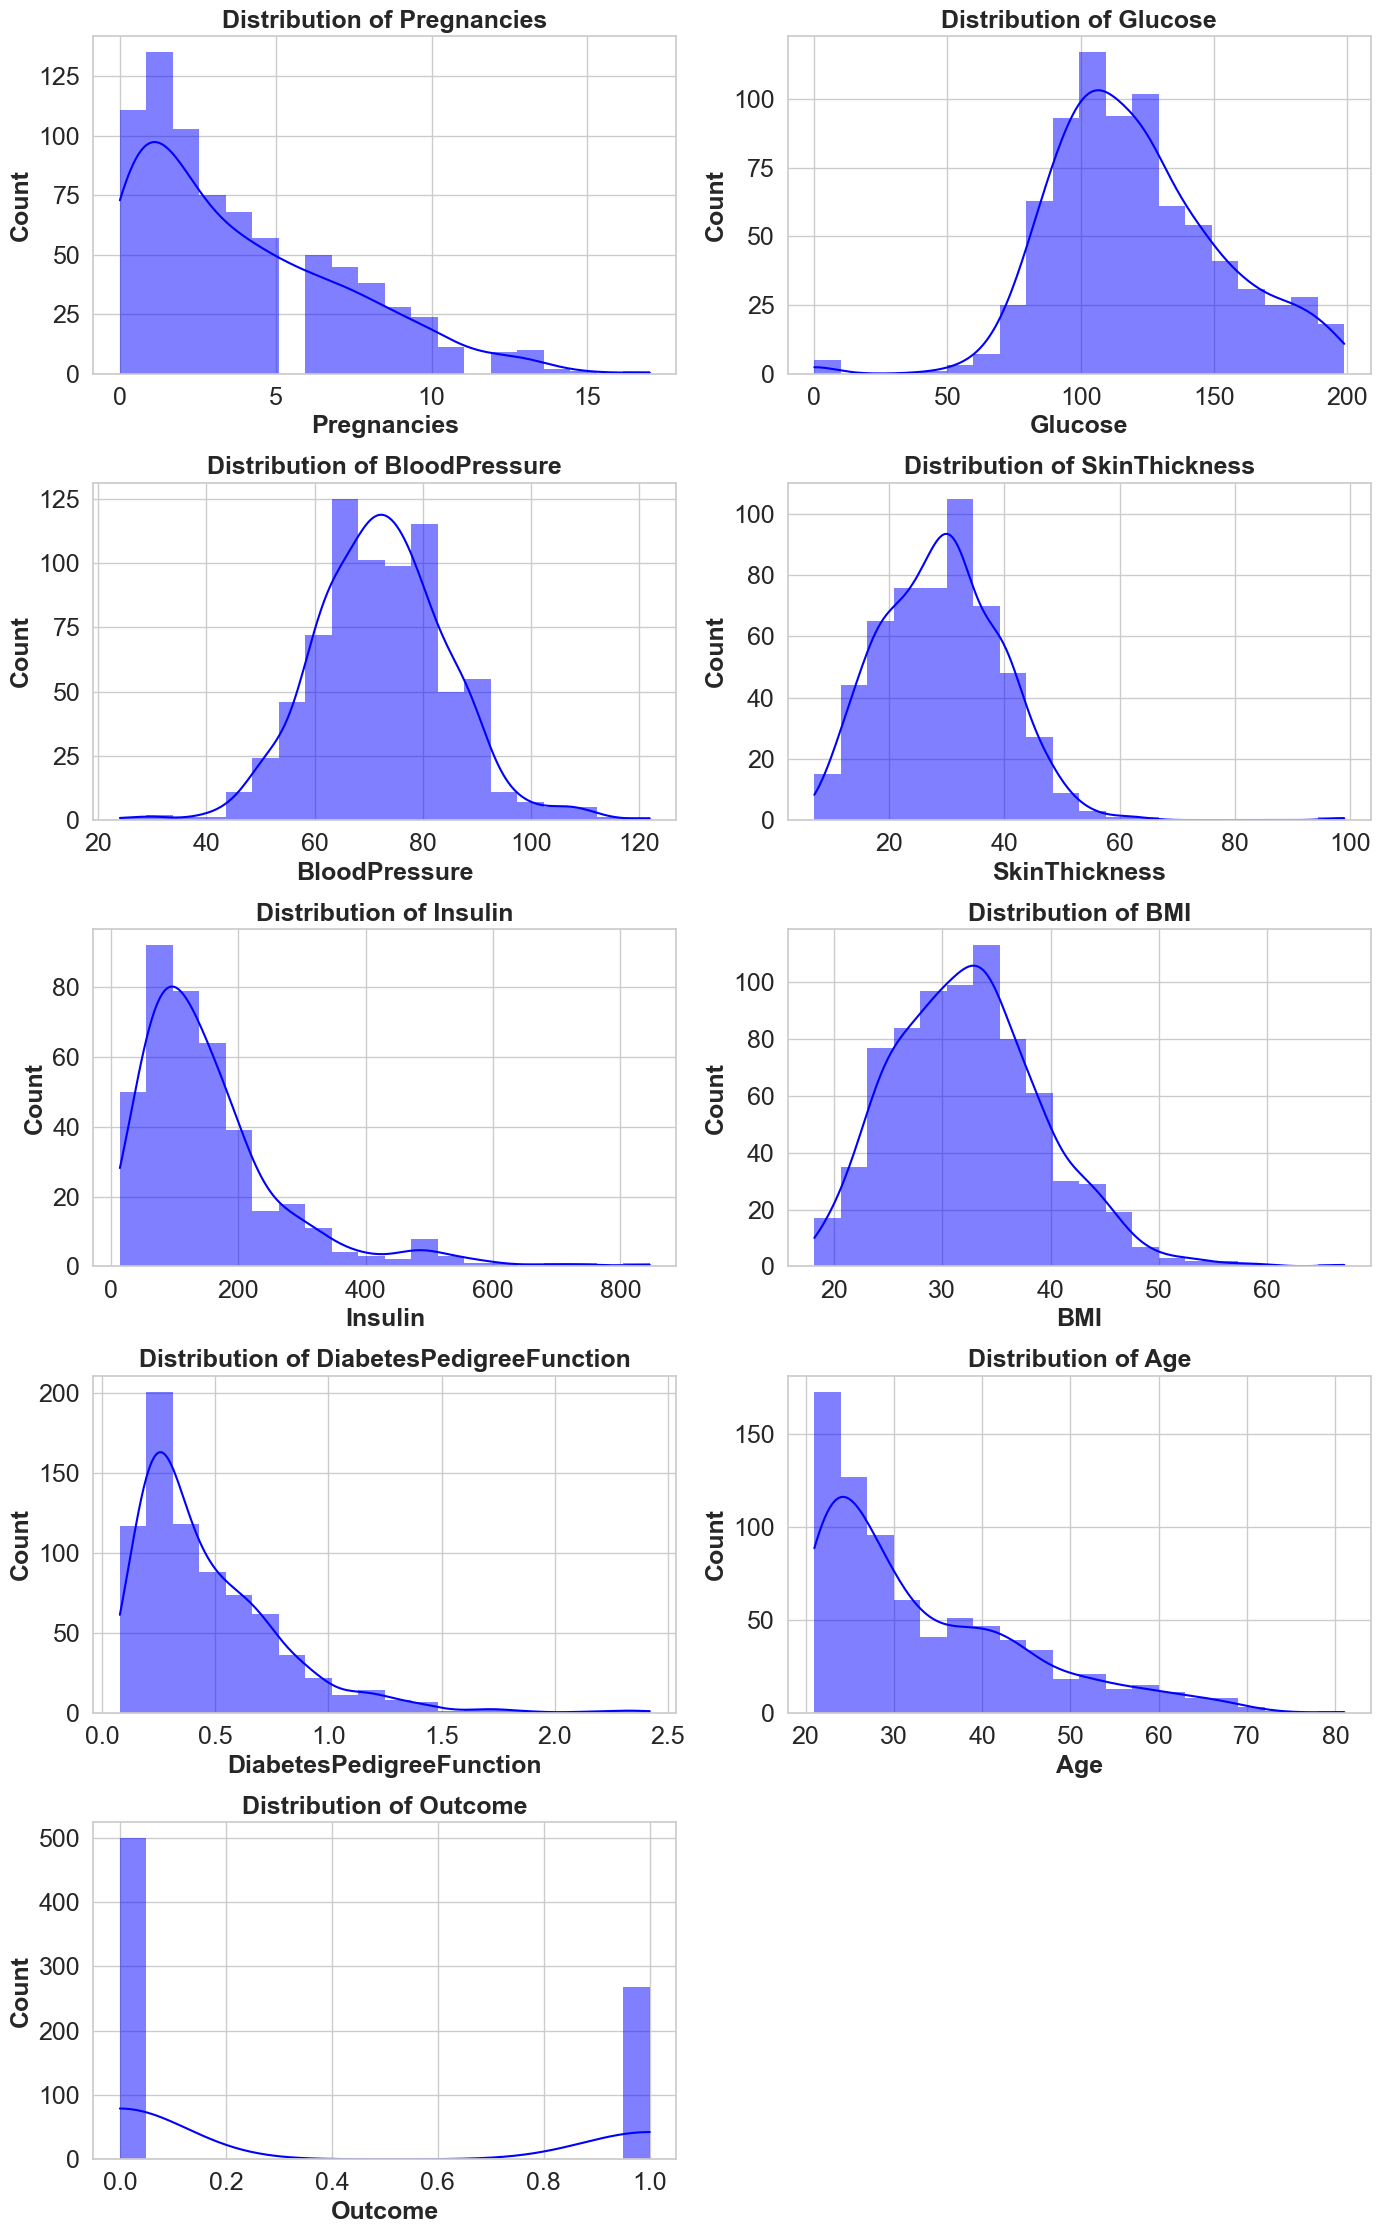

In [70]:
# Set style for better visualization
sns.set(style="whitegrid")

# Get all the numeric columns, including 'Outcome'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot layout: 2 histograms per row
fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(14, len(numeric_columns) * 2.5))

# Flatten the axes array to easily index into it
axes = axes.flatten()

# Plot histogram with KDE for each numerical feature, including Outcome
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], bins=20, kde=True, color='blue', stat='count', linewidth=0, ax=axes[i])

    # Set titles and labels with bigger, bold fonts
    axes[i].set_title(f'Distribution of {column}', fontsize=18, weight='bold')
    axes[i].set_xlabel(column, fontsize=18, weight='bold')
    axes[i].set_ylabel('Count', fontsize=18, weight='bold')

    # Set tick parameters with larger font size
    axes[i].tick_params(axis='both', which='major', labelsize=18)

# Remove empty subplots if any
if len(numeric_columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [71]:
from scipy.stats import shapiro

# Exclude the 'Outcome' column
columns_to_test = df.columns[df.columns != 'Outcome']

# Test for normality using Shapiro-Wilk Test on all columns except 'Outcome'
for col in columns_to_test:
    # Drop missing values for Shapiro test
    data_col = df[col].dropna()
    
    stat, p_value = shapiro(data_col)
    print(f'{col} - Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    
    if p_value > 0.05:
        print(f"The {col} column is normally distributed (p-value = {p_value:.4f})\n")
    else:
        print(f"The {col} column is NOT normally distributed (p-value = {p_value:.4f})\n")

Pregnancies - Shapiro-Wilk Test Statistic: 0.9043, p-value: 0.0000
The Pregnancies column is NOT normally distributed (p-value = 0.0000)

Glucose - Shapiro-Wilk Test Statistic: 0.9701, p-value: 0.0000
The Glucose column is NOT normally distributed (p-value = 0.0000)

BloodPressure - Shapiro-Wilk Test Statistic: 0.9903, p-value: 0.0001
The BloodPressure column is NOT normally distributed (p-value = 0.0001)

SkinThickness - Shapiro-Wilk Test Statistic: 0.9680, p-value: 0.0000
The SkinThickness column is NOT normally distributed (p-value = 0.0000)

Insulin - Shapiro-Wilk Test Statistic: 0.8041, p-value: 0.0000
The Insulin column is NOT normally distributed (p-value = 0.0000)

BMI - Shapiro-Wilk Test Statistic: 0.9796, p-value: 0.0000
The BMI column is NOT normally distributed (p-value = 0.0000)

DiabetesPedigreeFunction - Shapiro-Wilk Test Statistic: 0.8365, p-value: 0.0000
The DiabetesPedigreeFunction column is NOT normally distributed (p-value = 0.0000)

Age - Shapiro-Wilk Test Statisti

In [72]:
# Define the feature columns
# None is normally distributed
robust_columns = ['BloodPressure', 'Insulin', 'SkinThickness', 'Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies']
standard_columns = []
target_column = 'Outcome'

# Prepare X and y
X = df[robust_columns + standard_columns]
y = df[target_column]

# Split the dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [73]:
# Implementing a basic Perceptron model from scratch with early stopping
class PerceptronScratch:
    def __init__(self, input_dim, learning_rate=0.001, l1_penalty=0.0, l2_penalty=0.0):
        self.weights = np.zeros(input_dim)
        self.bias = 0
        self.learning_rate = learning_rate
        self.l1_penalty = l1_penalty  # L1 regularization
        self.l2_penalty = l2_penalty  # L2 regularization

    def activation(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))  # Sigmoid activation function

    def loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss"""
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError("Model weights or bias are not initialized.")
        
        if X is None:
            raise ValueError("Input data (X) is None.")

        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)

    def train(self, X, y, X_val, y_val, num_epochs=100, early_stopping_patience=20):
        best_weights = None
        best_bias = None
        best_val_loss = np.inf  # Track validation loss
        patience_counter = 0

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                linear_output = np.dot(X[i], self.weights) + self.bias
                y_pred = self.activation(linear_output)

                # Compute the error
                error = y[i] - y_pred

                # Update weights with L1 and L2 regularization
                self.weights += self.learning_rate * error * X[i]
                # Apply L1 penalty (Lasso)
                self.weights -= self.learning_rate * self.l1_penalty * np.sign(self.weights)
                # Apply L2 penalty (Ridge)
                self.weights -= self.learning_rate * self.l2_penalty * self.weights

                self.bias += self.learning_rate * error

            # Evaluate on the validation set at the end of each epoch
            y_val_pred = self.predict(X_val)
            val_loss = np.mean(self.loss(y_val, y_val_pred))  # Compute validation loss

            # Early stopping check: save the best weights if the validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = np.copy(self.weights)  # Save best weights
                best_bias = self.bias
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # If patience counter exceeds the early_stopping_patience, stop training
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}. Reverting to best weights.")
                self.weights = best_weights  # Revert to best weights
                self.bias = best_bias
                break

    def evaluate(self, X):
        if X is None:
            raise ValueError("Input data (X) is None.")
        
        linear_output = np.dot(X, self.weights) + self.bias
        predictions = self.activation(linear_output)
        return np.where(predictions >= 0.5, 1, 0)  # Convert probabilities to binary output

    def predict_proba(self, X):
        """Get the probability predictions"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)  # Probabilities for AUC calculation

    def save_model(self, filename):
        """Save the model (weights and bias) to a file."""
        np.savez(filename, weights=self.weights, bias=self.bias)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        """Load the model (weights and bias) from a file."""
        model_data = np.load(filename)
        self.weights = model_data['weights']
        self.bias = model_data['bias']
        print(f"Model loaded from {filename}")


# Perform cross-validation and store OOF predictions, probabilities, and labels
# Perform cross-validation and store OOF predictions, probabilities, and labels
def cross_validate_perceptron_with_early_stopping(X, y, num_epochs=100, learning_rate=0.001,
                                                  l1_penalty=0.0, l2_penalty=0.0, cv_splits=10,
                                                  early_stopping_patience=10,
                                                  output_csv="training_results.csv", file_name='final_model'):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    oof_predictions = np.zeros(X.shape[0])  # To store out-of-fold predictions
    oof_probabilities = np.zeros(X.shape[0])  # To store predicted probabilities

    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split the data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Preprocessing pipeline for each fold
        if not robust_columns:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('standard', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), standard_columns)
                ]
            )
        elif not standard_columns:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('robust', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', RobustScaler())
                    ]), robust_columns)
                ]
            )
        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('robust', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', RobustScaler())
                    ]), robust_columns),
                    ('standard', Pipeline([
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), standard_columns)
                ]
            )

        # Preprocess the training and validation data
        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        # Initialize the perceptron with regularization penalties
        perceptron = PerceptronScratch(
            input_dim=X_train_processed.shape[1],
            learning_rate=learning_rate,
            l1_penalty=l1_penalty,  # Pass L1 penalty
            l2_penalty=l2_penalty   # Pass L2 penalty
        )

        # Train the perceptron with early stopping based on validation loss
        perceptron.train(X_train_processed, y_train.values, X_val_processed, y_val.values, num_epochs=num_epochs, early_stopping_patience=early_stopping_patience)

        # Get out-of-fold predictions for validation set
        y_pred_val = perceptron.evaluate(X_val_processed)
        y_prob_val = perceptron.predict_proba(X_val_processed)

        # Store OOF predictions and probabilities
        oof_predictions[val_idx] = y_pred_val
        oof_probabilities[val_idx] = y_prob_val

        # Calculate metrics for the fold
        acc = accuracy_score(y_val.values, y_pred_val)
        recall = recall_score(y_val.values, y_pred_val)
        bal_acc = balanced_accuracy_score(y_val.values, y_pred_val)
        auc_score = roc_auc_score(y_val.values, y_prob_val)
        f1 = f1_score(y_val.values, y_pred_val)  # Added F1 score
        tn, fp, fn, tp = confusion_matrix(y_val.values, y_pred_val).ravel()
        specificity = tn / (tn + fp)

        # Print metrics for each fold
        print(f"Fold {fold + 1} - Accuracy: {acc:.4f}, Recall: {recall:.4f}, Balanced Accuracy: {bal_acc:.4f}, AUC: {auc_score:.4f}, F1: {f1:.4f}, Specificity: {specificity:.4f}")
        cv_scores.append([acc, recall, bal_acc, auc_score, f1, specificity])

    # Calculate and print the average and standard deviation cross-validated metrics
    cv_scores = np.array(cv_scores)
    avg_acc, std_acc = cv_scores[:, 0].mean(), cv_scores[:, 0].std()
    avg_recall, std_recall = cv_scores[:, 1].mean(), cv_scores[:, 1].std()
    avg_bal_acc, std_bal_acc = cv_scores[:, 2].mean(), cv_scores[:, 2].std()
    avg_auc, std_auc = cv_scores[:, 3].mean(), cv_scores[:, 3].std()
    avg_f1, std_f1 = cv_scores[:, 4].mean(), cv_scores[:, 4].std()
    avg_specificity, std_specificity = cv_scores[:, 5].mean(), cv_scores[:, 5].std()

    print(f"\nAverage CV Metrics - Accuracy: {avg_acc:.4f} ± {std_acc:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, "
          f"Balanced Accuracy: {avg_bal_acc:.4f} ± {std_bal_acc:.4f}, AUC: {avg_auc:.4f} ± {std_auc:.4f}, "
          f"F1: {avg_f1:.4f} ± {std_f1:.4f}, Specificity: {avg_specificity:.4f} ± {std_specificity:.4f}")

    # Check if the CSV file exists, and if it does not exist or is empty, write the header
    write_header = not os.path.exists(output_csv) or os.path.getsize(output_csv) == 0

    # Log the average and standard deviation results to the CSV at the end of training
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)
        if write_header:
            writer.writerow(['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 
                             'accuracy', 'accuracy_std', 'recall', 'recall_std', 
                             'specificity', 'specificity_std', 'auc', 'auc_std', 
                             'balanced_accuracy', 'balanced_accuracy_std', 'f1', 'f1_std'])

        writer.writerow([f'{file_name}.npz', learning_rate, num_epochs, l1_penalty, l2_penalty, 
                         avg_acc, std_acc, avg_recall, std_recall, 
                         avg_specificity, std_specificity, avg_auc, std_auc, 
                         avg_bal_acc, std_bal_acc, avg_f1, std_f1])

    # Save OOF data
    save_oof_data(f'model/oof_data-{file_name}.npz', oof_predictions, oof_probabilities, y)

    # Save the preprocessor
    save_preprocessor(preprocessor, f'model/Preprocessor-{file_name}.pkl')

    # Save Model Data
    perceptron.save_model(f'model/{file_name}.npz')

    return perceptron, preprocessor



# Save OOF predictions, probabilities, and y to an .npz file
def save_oof_data(filename, oof_predictions, oof_probabilities, y_train):
    np.savez(filename, oof_predictions=oof_predictions, oof_probabilities=oof_probabilities, y_train=y_train)
    print(f"OOF data saved to {filename}")

# Function to save the preprocessor using joblib
def save_preprocessor(preprocessor, filename):
    joblib.dump(preprocessor, filename)
    print(f"Preprocessor saved to {filename}")

from joblib import Parallel, delayed

# Modify run_all_combinations to include L1 and L2 penalties and run in parallel
def run_single_combination(X_train_full, y_train_full, lr, l1_penalty, l2_penalty, num_epochs, cv_splits, output_csv, i):
    print(f"Running with learning_rate={lr}, L1={l1_penalty}, L2={l2_penalty}")

    # Perform cross-validation and save OOF data, preprocessor, and model
    perceptron, preprocessor = cross_validate_perceptron_with_early_stopping(
        X_train_full, y_train_full,
        num_epochs=num_epochs,
        learning_rate=lr,
        l1_penalty=l1_penalty,  # Pass L1 penalty
        l2_penalty=l2_penalty,  # Pass L2 penalty
        cv_splits=cv_splits,
        early_stopping_patience=10,  # Add patience for early stopping
        output_csv=output_csv,
        file_name=f'Model-{i}'
    )
    return perceptron, preprocessor

def run_all_combinations(X_train_full, y_train_full, learning_rates, l1_penalties, l2_penalties, num_epochs=100, cv_splits=10, output_csv="training_results_combinations.csv"):
    param_combinations = list(itertools.product(learning_rates, l1_penalties, l2_penalties))

    # Use joblib to parallelize the execution of each parameter combination
    results = Parallel(n_jobs=-1)(delayed(run_single_combination)(
        X_train_full, y_train_full, lr, l1_penalty, l2_penalty, num_epochs, cv_splits, output_csv, i
    ) for i, (lr, l1_penalty, l2_penalty) in enumerate(param_combinations, 1))


In [74]:
learning_rates = [1, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
l1_penalties = [0, 0.01, 0.03, 0.05, 0.07, 1.0, 2.0, 3.0]  # Adjust L1 regularization strength
l2_penalties = [0, 0.01, 0.03, 0.05, 0.07, 1.0, 2.0, 3.0]  # Adjust L2 regularization strength

run_all_combinations(X_train_full, y_train_full, learning_rates, l1_penalties, l2_penalties, num_epochs=150, cv_splits=10, output_csv="training_results_combinations.csv")

In [95]:
import pandas as pd
from prettytable import PrettyTable

# Load the training results
results = pd.read_csv('training_results_combinations.csv')

# Function to get the top N models for each metric with relevant details and formatted as percentage
def get_top_n_models_with_details_for_each_metric(results_df, n):
    metrics = {
        'accuracy': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'accuracy', 'accuracy_std'],
        'recall': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'recall', 'recall_std'],
        'specificity': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'specificity', 'specificity_std'],
        'auc': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'auc', 'auc_std'],
        'balanced_accuracy': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'balanced_accuracy', 'balanced_accuracy_std'],
        'f1': ['filename', 'learning_rate', 'epoch', 'l1_penalty', 'l2_penalty', 'f1', 'f1_std']
    }
    
    top_n_dict = {}

    # Format the columns that represent percentages
    for metric, cols in metrics.items():
        df_copy = results_df[cols].copy()
        for col in ['accuracy', 'accuracy_std', 'recall', 'recall_std', 'specificity', 'specificity_std', 'auc', 'auc_std', 'balanced_accuracy', 'balanced_accuracy_std', 'f1', 'f1_std']:
            if col in df_copy.columns:
                df_copy[col] = (df_copy[col] * 100).round(2)  # Convert to percentage and round to 2 decimal places
        top_n_dict[metric] = df_copy.sort_values(by=metric, ascending=False).head(n)
    
    return top_n_dict

# Function to print the top N models in pretty table format
def print_pretty_table(top_n_models, metric):
    table = PrettyTable()
    table.field_names = top_n_models.columns.tolist()

    for index, row in top_n_models.iterrows():
        table.add_row(row.tolist())
    
    print(f"\nTop {len(top_n_models)} Models for {metric.capitalize()}:")
    print(table)

# Choose whether you want top 5 or top 3 models
n = 3

# Get the top N models with full details for each metric
top_n_models_with_details = get_top_n_models_with_details_for_each_metric(results, n)

# Print the top N models for each metric in a pretty table
for metric, top_n in top_n_models_with_details.items():
    print_pretty_table(top_n, metric)



Top 3 Models for Accuracy:
+---------------+---------------+-------+------------+------------+----------+--------------+
|    filename   | learning_rate | epoch | l1_penalty | l2_penalty | accuracy | accuracy_std |
+---------------+---------------+-------+------------+------------+----------+--------------+
| Model-449.npz |     0.001     |  150  |    0.0     |    0.0     |  76.69   |     4.39     |
| Model-457.npz |     0.001     |  150  |    0.01    |    0.0     |  76.38   |     3.57     |
| Model-385.npz |     0.005     |  150  |    0.0     |    0.0     |  76.08   |     4.17     |
+---------------+---------------+-------+------------+------------+----------+--------------+

Top 3 Models for Recall:
+---------------+---------------+-------+------------+------------+--------+------------+
|    filename   | learning_rate | epoch | l1_penalty | l2_penalty | recall | recall_std |
+---------------+---------------+-------+------------+------------+--------+------------+
| Model-193.npz | 

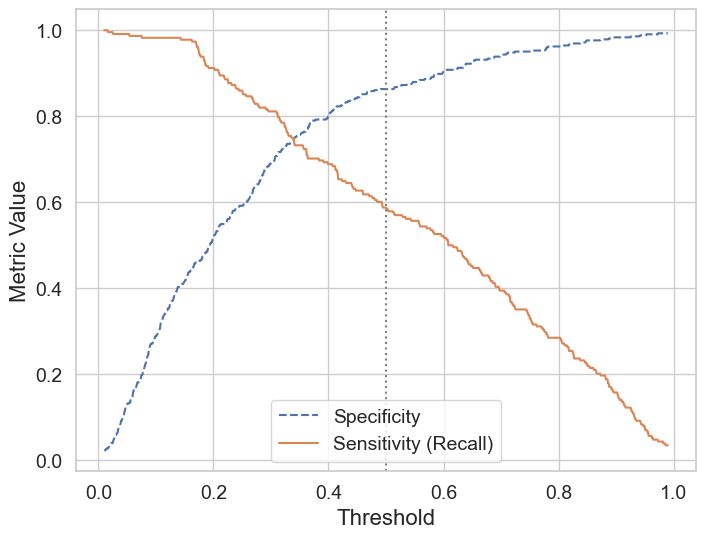

Optimal Threshold (closest specificity and sensitivity): 0.34
At this threshold -> Specificity: 0.7476, Sensitivity: 0.7500
Threshold at Recall 80%: 0.31, Specificity: 0.7075, Sensitivity: 0.8070
Threshold at Recall 90%: 0.20, Specificity: 0.5236, Sensitivity: 0.9079


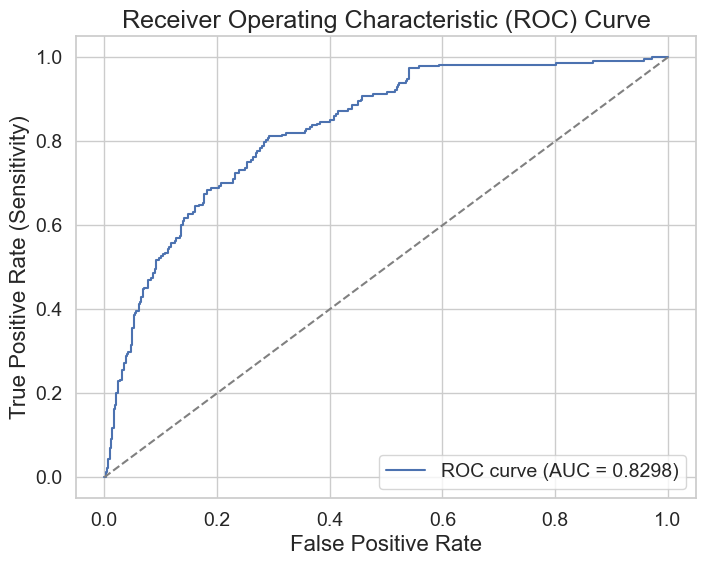

{'optimal_threshold': 0.3396096096096096, 'recall_80': {'threshold': 0.3101801801801802, 'specificity': 0.7075471698113207, 'sensitivity': 0.8070175438596491}, 'recall_90': {'threshold': 0.20227227227227226, 'specificity': 0.5235849056603774, 'sensitivity': 0.9078947368421053}}


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def compute_specificity_sensitivity(y_true, y_prob, threshold):
    """
    Compute specificity and sensitivity (recall) for a given threshold.

    Parameters:
    - y_true: True labels
    - y_prob: Predicted probabilities
    - threshold: The threshold for classification

    Returns:
    - specificity: Specificity at the given threshold
    - sensitivity: Sensitivity (recall) at the given threshold
    """
    y_pred = np.where(y_prob >= threshold, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    return specificity, sensitivity

def tune_threshold_and_plot(oof_probabilities, y_train):
    """
    Tune the threshold and plot specificity vs. sensitivity, and generate ROC curve.

    Parameters:
    - oof_probabilities: Probabilities from out-of-fold predictions
    - y_train: True labels of the training set

    Returns:
    - A dictionary containing:
        - Optimal threshold where specificity and sensitivity are closest
        - Threshold when recall reaches 80% and 90%
    """
    # Set larger font sizes
    plt.rcParams.update({'font.size': 14})  # Globally set font size

    thresholds = np.linspace(0.01, 0.99, 1000)
    specificities = []
    sensitivities = []
    recall_80 = None
    recall_90 = None

    for threshold in thresholds:
        specificity, sensitivity = compute_specificity_sensitivity(y_train, oof_probabilities, threshold)
        specificities.append(specificity)
        sensitivities.append(sensitivity)

        # Capture threshold where recall (sensitivity) reaches exactly 80% and 90%
        if recall_80 is None and 0.79 <= sensitivity <= 0.81:
            recall_80 = {'threshold': threshold, 'specificity': specificity, 'sensitivity': sensitivity}
        
        if recall_90 is None and 0.89 <= sensitivity <= 0.91:
            recall_90 = {'threshold': threshold, 'specificity': specificity, 'sensitivity': sensitivity}

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, specificities, label='Specificity', linestyle='--')
    plt.plot(thresholds, sensitivities, label='Sensitivity (Recall)', linestyle='-')
    plt.axvline(x=0.5, color='gray', linestyle=':')
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Metric Value', fontsize=16)
    plt.title('Specificity vs Sensitivity Across Thresholds', fontsize=18)
    plt.legend(fontsize=14)
    
    # Adjust the font size of x-axis and y-axis ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.grid(True)
    plt.show()

    # Find and print the optimal threshold where specificity and sensitivity are closest
    differences = np.abs(np.array(specificities) - np.array(sensitivities))
    optimal_idx = np.argmin(differences)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (closest specificity and sensitivity): {optimal_threshold:.2f}")
    print(f"At this threshold -> Specificity: {specificities[optimal_idx]:.4f}, Sensitivity: {sensitivities[optimal_idx]:.4f}")

    # Print recall 80% and 90% thresholds
    if recall_80:
        print(f"Threshold at Recall 80%: {recall_80['threshold']:.2f}, Specificity: {recall_80['specificity']:.4f}, Sensitivity: {recall_80['sensitivity']:.4f}")
    if recall_90:
        print(f"Threshold at Recall 90%: {recall_90['threshold']:.2f}, Specificity: {recall_90['specificity']:.4f}, Sensitivity: {recall_90['sensitivity']:.4f}")

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, roc_thresholds = roc_curve(y_train, oof_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc='lower right', fontsize=14)
    
    # Adjust the font size of x-axis and y-axis ticks for ROC curve
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.grid(True)
    plt.show()

    return {
        'optimal_threshold': optimal_threshold,
        'recall_80': recall_80,
        'recall_90': recall_90
    }

# Example usage:
# results = tune_threshold_and_plot(oof_probabilities, y_train)


model_number = '449'
# Load OOF data from a specific model file (for example, Model-6.npz)
oof_predictions, oof_probabilities, y_train = load_oof_data(f'model/oof_data-Model-{model_number}.npz')

# Tune the threshold using OOF predictions and generate ROC curve
print(tune_threshold_and_plot(oof_probabilities, y_train))


In [121]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

# Function to load the preprocessor using joblib
def load_preprocessor(filename):
    return joblib.load(filename)

def evaluate_perceptron_on_test_with_threshold(X_test, y_test, preprocessor, model_file, threshold=0.5):
    """
    Function to evaluate the Perceptron model on the test set with a specific threshold.

    Parameters:
    - X_test: The test data features
    - y_test: The test data labels
    - preprocessor: The preprocessing pipeline used during training
    - model_file: Path to the saved model file
    - threshold: The threshold to convert probabilities into binary predictions (default is 0.5)

    Returns:
    - Prints the test set metrics
    """
    # Preprocess the test set
    X_test_processed = preprocessor.transform(X_test)

    # Load the trained Perceptron model
    perceptron = PerceptronScratch(input_dim=X_test_processed.shape[1])
    perceptron.load_model(model_file)

    # Get predicted probabilities for the test set
    y_test_prob = perceptron.predict_proba(X_test_processed)

    # Convert probabilities to binary predictions based on the given threshold
    y_test_pred = np.where(y_test_prob >= threshold, 1, 0)

    # Calculate metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    test_specificity = tn / (tn + fp)

    # Print the test set results
    print(f"\nTest Set Metrics with threshold {threshold:.2f} - Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Balanced Accuracy: {test_bal_acc:.4f}, AUC: {test_auc:.4f}, Specificity: {test_specificity:.4f}")

    return test_acc, test_recall, test_bal_acc, test_auc, test_specificity

model_number = '449'
threshold = 0.34

# Load OOF data from a specific model file (for example, Model-6.npz)
oof_predictions, oof_probabilities, y_train = load_oof_data(f'model/oof_data-Model-{model_number}.npz')

# Tune the threshold using OOF predictions and generate ROC curve
evaluate_perceptron_on_test_with_threshold(X_test, y_test, load_preprocessor(f'model/Preprocessor-Model-{model_number}.pkl'), f'model/Model-{model_number}.npz', threshold=threshold)


Model loaded from model/Model-449.npz

Test Set Metrics with threshold 0.34 - Accuracy: 0.7328, Recall: 0.8000, Balanced Accuracy: 0.7487, AUC: 0.8197, Specificity: 0.6974


(0.7327586206896551,
 0.8,
 0.7486842105263158,
 0.8197368421052632,
 0.6973684210526315)